<body>
    <font size="2">Florian Schnabel, 11807470, WS 2024</font><br />
</body>

# Excersise 5  - Air flow through a rectangular-channel

This script aims to calculate the air flow through a two dimensional channel in a steady state. A depiction of such a channel can be seen in {numref}`fig:channel`. 

```{figure} ./Figures/channel.png
---
width: 350px
name: fig:channel
---
Depiction of a rectangular channel [excersise Description] {cite}`hagenthoft2001`
```

Assuming flow thorugh a prous medium the airflow can be described by Darcy's Law :

$$ \dot{m}_a = - \frac{\rho_a \cdot k}{\mu} \nabla P $$

For low air speed, air can be aproximated as an incompressible fluid ($\frac{\delta \rho_a}{\delta x} = \frac{\delta \rho_a}{\delta y}  = const.$). Further assuming $\mu,k = const.$ leads to a constant mass flow in the channel:

$$ \nabla^2 P = 0 $$ (gl:laplace)

## Analytical Solution

For a steady flow in rectangular channel the Navier–Stokes Equations can be solved analytically leading to an explixcit solution of the average velocity in the channel {numref}`gl:anasol` {cite}`deville2022`:

$$ v_{avg} = \frac{h^2}{12 \mu} \frac{\delta P}{L} $$ (gl:anasol)



## Numerical Solution

The steady state can solved by solving a linear equation System in the following form:

$$ \tilde{A} \cdot \vec{x} = \vec{b} $$ (gl:LEM)

with:
* $\tilde{A}\ \dots$ "Laplace Matrix"
    * Discretization
    * Neumann Conditions
    * tranpsort coefficients
* $b\ \dots$ Initial state
    * Dirchilet Boundary conditions
    * Sources
* $x\ \dots$ unknown Pressure Field


## Space Discretization

To allow an assambly in the LEM the Cells are discretized using an index the shema shown in {numref}`fig:discretization`. 

```{figure} ./Figures/discretization.png
---
width: 350px
name: fig:discretization
---
Depiction of the Discretization Shema
```

Discretising {numref}`gl:laplace` for an interior cell leads to:
$$ A_P \cdot P_P + A_E \cdot P_E + A_W \cdot P_W + A_N \cdot P_N + A_S \cdot P_S = 0 $$ (gl:Coeff)
with:
* $A_E = A_W = \Delta y / \Delta x$
* $A_N = A_S = \Delta x / \Delta y$
* $A_P = -2 (\Delta y / \Delta x+ \Delta y / \Delta x)$

Apllying $1/(\Delta x \Delta y)$ to {numref}`gl:coeff`, {numref}`gl:LEM` can be written as follows:

$$  b = \left[ 
\begin{array}{ccccccc}
      &   &  & & \cdots  &  &   &     \\
    \vdots &   &  & \ddots &  &   &   &   \\
      & \frac{1}{\Delta y^2} & \cdots & \frac{1}{\Delta y^2} & -(.\frac{2}{\Delta y^2}+\frac{2}{\Delta x^2}) & \frac{1}{\Delta x^2} & \cdots & \frac{1}{\Delta y^2} \\
    \vdots &   &  & &&\ddots &    \\
     &   &  & & \cdots  &  &   &   &   \\
\end{array}
\right] \cdot 
\left[
\begin{array}{c}
    P_1 \\
    \vdots \\
    P_{n-N_x} \\
    \vdots \\
    P_{n-1} \\
    P_n \\
    P_{n+1} \\
    \vdots \\
    P_{n+N_x} \\
    \vdots \\
    P_{N_yN_x} \\

\end{array}
\right]
$$

## Boundary conditions

### Neumann Condition

A Neumann Condition on the south side can be described as follows:

$$
\frac{\partial P}{\partial y} \approx \frac{P_N-P_S}{2 \Delta y}=0
$$

Discretising {numref}`gl:laplace` for an interior cell with a Neumann Condition to the south results in:

$$
\frac{1}{\Delta x^2} (P_E + P_W - 2 P_P) + \frac{1}{\Delta y^2} (2 P_N - 2 P_P)
$$

Which equals to multiplying the to $P_N$ corresbonding entry in $[A]$ by $2$ and setting the to $P_S$ corresbonding Value to $0$

### Dirichlet Condition

The Dirchilet Conditions are considered in the inital State vector as:

$$
P_i=P_{BC}
$$

Discretising {numref}`gl:laplace` for an interior cell with a Dirichlet Condition to the west results in:

$$
\frac{1}{\Delta x^2} (P_E + P_{BC} - 2 P_P) + \frac{1}{\Delta y^2} (P_S + P_N - 2 P_P)
$$

And therefore setting the to $P_W$ corresbonding entry in $[A]$ to $1$.

## Implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

In [ ]:
lx, ly = (1,1)
nx, ny = (1000, 1000)
deltax,deltay = (lx/nx , ly/ny)



In [ ]:
x = np.linspace(0, lx, nx)

y = np.linspace(0, ly, ny)

a,b = np.meshgrid(x, y)

### Construction of the System Matrix

In [ ]:
def newSystemMatrix_nx_ny(nx,ny,deltax,deltay):
    # returns a Systemmatrix, for constant boundary condition on the left and right side of the Domain
    I = sparse.lil_matrix( sparse.eye(nx*ny))
    # Main diagonal
    A = I * (-2/deltax**2 - 2 / deltay**2)
    # West / East diagonal
    A[range(1,nx*ny),range(0,nx*ny-1)]=1 / deltax**2
    A[range(0,ny*nx-1),range(1,nx*ny)]=1 / deltax**2
    # North / South diagonal
    A[range(nx,nx*ny),range(0,nx*ny-nx)]=1 / deltay**2
    A[range(0,ny*nx-nx),range(nx,nx*ny)]=1 / deltay**2
    
    # take Boundary Conditions into account
    # Dirichlet
    A[0,:] = 0; #Left
    A[-1,:] = 0; #Right
    for i in range(0,nx):
        #First cell of each row
        A[i*nx,:] = 0
        A[i*nx,i*nx] = 1
        #Last cell of each row
        A[i*nx+nx-1,:] = 0
        A[i*nx+nx-1,i*nx+nx-1] = 1
    #Neumann
    A[range(0,nx),range(nx,nx*2)]*=2  
    A[range(nx*ny - nx,nx*ny),range(nx*ny - 2*nx,nx*ny - nx)]*=2 #
    return A

In [ ]:
A = newSystemMatrix_nx_ny(nx,ny,deltax,deltay)

### Initial State

In [ ]:
def newPinit(nx,ny,Pbcr,Pbcl):
    P_init = np.zeros(nx*ny)
    for i in range(0,nx):
        P_init[i*nx] = Pbcr #Left side
        P_init[i*nx+nx-1] = Pbcl #Right side
    return P_init

In [ ]:
P_init = newPinit(nx,ny,20,15)

### Transport coefficients

In [ ]:
#height of the channel
h= 0.0002 #m
rho = 1.35 # kg/m-3
mu =  17.5e-6 #kg m-1 s-1
k = h**2/12

### Solving the Pressure Field

In [ ]:
def solveP(nx,ny,A,P_init):
    A_stat = A
    A_sparse = sparse.csr_matrix(A_stat)
    P = sparse.linalg.spsolve(A_sparse,P_init)
    P_matrix = P.reshape((nx,ny))
    return P_matrix
    

In [ ]:
P_matrix = solveP(nx,ny,A,P_init)

### Velocity field and averaging

In [ ]:
def averageV(P_matrix,deltax,nx,ny,mu,k):
    deltaPx, deltaPy = np.gradient(P_matrix,deltax) 
    v = np.sqrt(deltaPx**2+deltaPy**2) / mu * k
    return np.average(v[1:nx-1,1:ny-1])

In [ ]:
v_avg = averageV(P_matrix,deltax,nx,ny,mu,k)

### Comparision to Analytical Solution

In [ ]:
v_ana = h**2 / 12 / mu * (P_init[0] - P_init[-1]) / lx
print(v_ana,v_avg)

0.0009523809523809526 0.0009533342866676086


Text(0.5, 0, 'Pressure $P$ [Pa]')

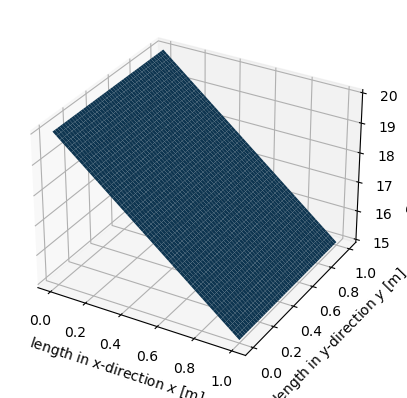

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(a[:nx,:nx],b[:nx,:nx],P_matrix[:nx,:nx])
ax.set_xlabel("length in x-direction $x$ [m]")
ax.set_ylabel("length in y-direction $y$ [m]")
ax.set_zlabel("Pressure $P$ [Pa]")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

## Convergence study

In [ ]:
def cvgStudy(gridsizes,lx,ly,Pbcr,Pbcl,h,mu):
    for tupel in gridsizes:
        nx = tupel[0]
        ny = tupel[1]
        print(nx,ny)
        deltax,deltay = (lx/nx , ly/ny)
        A = newSystemMatrix_nx_ny(nx,ny,deltax,deltay)
        P_init=newPinit(nx,ny,Pbcr,Pbcl)
        P_matrix = solveP(nx,ny,A,P_init)
        v_avg = averageV(P_matrix,deltax,nx,ny,mu,k)
        plt.scatter(tupel[0],v_avg,c=[0,0,1])
    v_ana = h**2 / 12 / mu * (P_init[0] - P_init[-1]) / lx
    plt.plot([0,gridsizes[-1][0]],[v_ana,v_ana])
    plt.xlabel("Number of cells per direction $nx,ny$")
    plt.ylabel("Average velocity in the channel $v_{avg}$ [m/s]")

In [ ]:
#transportcoefficients
#height of the channel
h= 0.0002 #m
rho = 1.35 # kg/m-3
mu =  17.5e-6 #kg m-1 s-1
k = h**2/12
#Boundary conditions
Pbcr = 20 #Pa
Pbcl = 15 #Pa
#Tested sizes
lx=1
ly=1
gridsizes = [(100,100),(200,200),(500,500),(1000,1000)]

100 100
200 200


/tmp/ipykernel_200562/1554237472.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tupel[0],v_avg,c=[0,0,1])


500 500
1000 1000


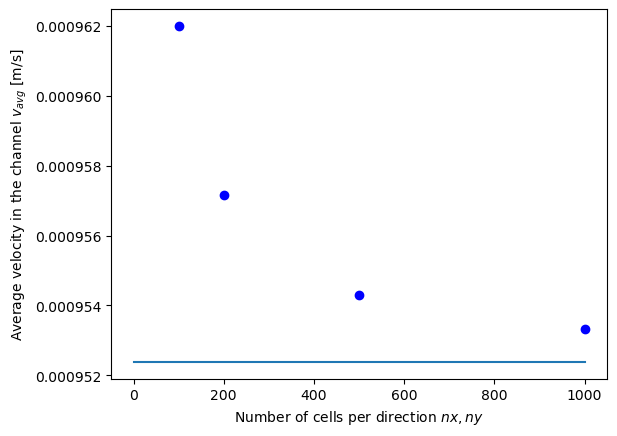

In [ ]:
cvgStudy(gridsizes,lx,ly,Pbcr,Pbcl,h,mu)